In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

2023-12-14 03:28:02.274308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 03:28:02.413815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 03:28:02.413841: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-14 03:28:02.444293: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 03:28:04.416422: W tensorflow/stream_executor/pla

# Thank you Sandya

In [ ]:
## Loading Datasets & Preprocessing

def preprocess(df, value):
    ## only want years 2011-2012
    # except for 2016
    required_columns = ['Province'] + [str(year) for year in range(2011, 2022) if (str(year) in df.columns) and year != 2016]
    filtered_df = df[required_columns]

    ## make it 1 row = 1 province at 1 year instead of 1 province
    melted_df = pd.melt(filtered_df, id_vars='Province', var_name='Year', value_name=value)

    ## making the datatype easy to work with
    # year object to datetime
    melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

    melted_df['Year'] = melted_df['Year'].apply(lambda x: x.year)

    # some rows have - as a value which cannot be converted to float, so turn to nan first
    melted_df[value] = pd.to_numeric(melted_df[value].replace('-', pd.NA), errors='coerce')

    return melted_df

target datasets

In [ ]:
# be mindful that this dataset does not have 2016 year
energy_consumption = pd.read_csv("/work/Energy Consumption.csv")
energy_consumption = preprocess(energy_consumption, 'energy_consumption')
energy_consumption

,Province,Year,energy_consumption
0,ACEH,2011,1579.77
1,SUMATERA UTARA,2011,7194.03
2,SUMATERA BARAT,2011,2403.10
3,RIAU,2011,2361.15
4,JAMBI,2011,1054.17
...,...,...,...
345,MALUKU,2021,582.88
346,MALUKU UTARA,2021,637.04
347,PAPUA BARAT,2021,583.21
348,PAPUA,2021,1237.64


In [ ]:
energy_generation = pd.read_csv("/work/Energy Generation.csv")
energy_generation = preprocess(energy_generation, 'energy_generation')
energy_generation

,Province,Year,energy_generation
0,ACEH,2011,1579.77
1,SUMATERA UTARA,2011,7194.03
2,SUMATERA BARAT,2011,2403.10
3,RIAU,2011,2361.15
4,JAMBI,2011,1054.17
...,...,...,...
345,MALUKU,2021,969.89
346,MALUKU UTARA,2021,377.04
347,PAPUA BARAT,2021,677.34
348,PAPUA,2021,1360.61


In [ ]:
energy_capacity = pd.read_csv("/work/Energy Capacity.csv")
energy_capacity = preprocess(energy_capacity, 'energy_capacity')
energy_capacity

,Province,Year,energy_capacity
0,ACEH,2011,159.26
1,SUMATERA UTARA,2011,2450.67
2,SUMATERA BARAT,2011,33.45
3,RIAU,2011,111.23
4,JAMBI,2011,12.82
...,...,...,...
345,MALUKU,2021,390.74
346,MALUKU UTARA,2021,157.88
347,PAPUA BARAT,2021,267.51
348,PAPUA,2021,525.64


features

socioeconomic

In [ ]:
homeowners = pd.read_csv("/work/Homeowners.csv")
homeowners.drop([35,36,37,38], inplace=True) # delete subtext
homeowners = preprocess(homeowners, 'prop_homeowners')
homeowners

,Province,Year,prop_homeowners
0,ACEH,2011,79.02
1,SUMATERA UTARA,2011,66.07
2,SUMATERA BARAT,2011,69.51
3,RIAU,2011,68.42
4,JAMBI,2011,78.02
...,...,...,...
345,MALUKU,2021,75.13
346,MALUKU UTARA,2021,83.40
347,PAPUA BARAT,2021,76.03
348,PAPUA,2021,83.20


In [ ]:
household_work = pd.read_csv("/work/Household working.csv")
household_work = household_work.rename(columns={'Unnamed: 0': 'Province'})
household_work = preprocess(household_work, 'prop_working')
household_work

,Province,Year,prop_working
0,Aceh,2011,87.13
1,Sumatera Utara,2011,90.28
2,Sumatera Barat,2011,86.66
3,R i a u,2011,91.90
4,J a m b i,2011,90.87
...,...,...,...
345,Maluku,2021,86.18
346,Maluku Utara,2021,89.85
347,Papua Barat,2021,91.64
348,P a p u a,2021,94.32


In [ ]:
school_inattend = pd.read_csv("/work/School Inattendance.csv")
school_inattend = preprocess(school_inattend, 'prop_school_absentees')
school_inattend

,Province,Year,prop_school_absentees
0,Aceh,2011,3.17
1,Sumatera Utara,2011,2.34
2,Sumatera Barat,2011,2.02
3,Riau,2011,2.39
4,Jambi,2011,3.56
...,...,...,...
345,Maluku,2021,2.27
346,Maluku Utara,2021,1.08
347,Papua Barat,2021,3.55
348,Papua,2021,25.55


In [ ]:
toilet_access = pd.read_csv("/work/Toilet Facility Access.csv")
toilet_access.drop([35,36,37,38,39], inplace=True) # delete subtext
toilet_access = preprocess(toilet_access, 'prop_toilet_access')
toilet_access

,Province,Year,prop_toilet_access
0,Aceh,2011,60.34
1,Sumatera Utara,2011,74.88
2,Sumatera Barat,2011,54.65
3,Riau,2011,83.81
4,Jambi,2011,68.12
...,...,...,...
345,Maluku,2021,72.87
346,Maluku Utara,2021,69.73
347,Papua Barat,2021,75.48
348,Papua,2021,63.34


economic

In [ ]:
gdp = pd.read_csv("/work/GDP.csv")
# gdp represented with columns
gdp = gdp.replace(',', '', regex=True)
# then preprocess
gdp = preprocess(gdp, 'gdp')
gdp

,Province,Year,gdp
0,Aceh,2011,108217.63
1,North Sumatra,2011,377037.10
2,West Sumatra,2011,118674.29
3,Riau,2011,485649.34
4,Jambi,2011,103522.91
...,...,...,...
345,Maluku,2021,48564.22
346,North Maluku,2021,52359.85
347,West Papua,2021,85072.86
348,Papua,2021,235343.25


In [ ]:
population = pd.read_csv("/work/Population.csv")
population = preprocess(population, 'population')
population

,Province,Year,population
0,Aceh,2011,4619.0
1,Sumatera Utara,2011,13220.0
2,Sumatera Barat,2011,4933.0
3,Riau,2011,5726.0
4,Kep. Riau,2011,3168.0
...,...,...,...
345,Maluku,2021,1862.6
346,Maluku Utara,2021,1299.2
347,Papua Barat,2021,1156.8
348,Papua,2021,4355.5


physical / climate

In [ ]:
# note! missing 2011
land_area = pd.read_csv("/work/Land Area.csv")
# Loop through specified columns, remove spaces
columns_to_convert = [str(year) for year in range(2011, 2022)]
for column_name in columns_to_convert:
    land_area[column_name] = land_area[column_name].str.replace(' ', '')

land_area = preprocess(land_area, 'land_area')
land_area

,Province,Year,land_area
0,Aceh,2011,57956.00
1,Sumatera Utara,2011,72981.23
2,Sumatera Barat,2011,42012.89
3,Riau,2011,87023.66
4,Kepulauan Riau,2011,8201.72
...,...,...,...
345,Maluku,2021,46914.03
346,Maluku Utara,2021,31982.50
347,Papua,2021,319036.05
348,Papua Barat,2021,99671.63


In [ ]:
# note! missing 2016, 2017, 2018, 2019, 2020, 2021
rainy_days = pd.read_csv("/work/Rainy Days.csv")
rainy_days = preprocess(rainy_days, 'num_rainy_days')
rainy_days

,Province,Year,num_rainy_days
0,Aceh,2011,150.0
1,Sumatera Utara,2011,225.0
2,Sumatera Barat,2011,NaN
3,Riau,2011,211.0
4,Jambi,2011,209.0
...,...,...,...
165,Sulawesi Barat,2015,93.0
166,Maluku,2015,167.0
167,Maluku Utara,2015,127.0
168,Papua Barat,2015,218.0


Combine to create final dataframe

In [ ]:
dfs_list = [energy_consumption, energy_generation, energy_capacity, homeowners, household_work, school_inattend, toilet_access,gdp, population, land_area]  # Add all your datasets here
combined_df = pd.concat(dfs_list, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df

,Province,Year,energy_consumption,energy_generation,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,1579.77,1579.77,159.26,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00
1,SUMATERA UTARA,2011,7194.03,7194.03,2450.67,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23
2,SUMATERA BARAT,2011,2403.10,2403.10,33.45,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89
3,RIAU,2011,2361.15,2361.15,111.23,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66
4,JAMBI,2011,1054.17,1054.17,12.82,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72
...,...,...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,2021,582.88,969.89,390.74,75.13,86.18,2.27,72.87,48564.22,1862.6,46914.03
346,MALUKU UTARA,2021,637.04,377.04,157.88,83.40,89.85,1.08,69.73,52359.85,1299.2,31982.50
347,PAPUA BARAT,2021,583.21,677.34,267.51,76.03,91.64,3.55,75.48,85072.86,1156.8,319036.05
348,PAPUA,2021,1237.64,1360.61,525.64,83.20,94.32,25.55,63.34,235343.25,4355.5,99671.63


note! all target datasets are missing year 2016 so energy_consumption, energy_generation, energy_capacity in that year are nans (we have 35 nan values for all target variables) -- this is also shown in how even if all datasets go through the same preprocessing function, these 3 datasets have 350 rows and all other datasets have 385 rows should be good

# Ethan Edits

## Notes

Edits: 
- made year just the year rather than like a timestamp
- got rid of all rows with year of 2016

Need to change it to look like the example df; 
2011 features with 2014 target variable 
-->
2018 features with 2021 target variable 

therefore, we don't need any data after 2018

## Feature_df: Generation and Description

In [ ]:
drop_post_2019 = combined_df[combined_df['Year'] < 2019]
feature_df = drop_post_2019.drop(['energy_consumption', 'energy_generation', 'energy_capacity'], axis=1)
feature_df

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72
...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63


In [ ]:
count = 0
for col in feature_df.columns:
    num_nans = feature_df[col].isna().sum()
    count += num_nans
    print(col + ': ' + str(num_nans))
print(count)

Province: 0
Year: 0
prop_homeowners: 4
prop_working: 4
prop_school_absentees: 4
prop_toilet_access: 4
gdp: 2
population: 6
land_area: 0
24


## Add Target(s) to feature_df

In [ ]:
def add_target_to_feature_df(feature_df, target_df, target_name):
    full_df = feature_df.copy()
    clean_target = target_df[target_df['Year'] >= 2014].reset_index()
    full_df['target: ' + target_name] = clean_target[target_name]

    print('num nans in target col: ' + str(clean_target[target_name].isna().sum()))

    return full_df

In [ ]:
ecap_df = add_target_to_feature_df(feature_df, energy_capacity, 'energy_capacity')
ecap_df

num nans in target col: 4


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,target: energy_capacity
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,201.25
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,4116.45
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,72.67
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,172.62
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,51.54
...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,390.74
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,157.88
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,267.51
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,525.64


# Our final test year

# Modeling

In [ ]:
def print_metrics(y_true,y_pred):
    # report performance
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    print('MAPE: '+str(mape))

## Linear Regression

In [ ]:
pq2_df = ecap_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq2_df.drop('target: energy_capacity', axis=1)
y = pq2_df['target: energy_capacity']

### Model - chosen features vs. all

LR using all features is better

In [ ]:
X_imp = X.drop(['land_area','population','gdp','prop_working'], axis=1)

ecap_Ximp_train, ecap_Ximp_test, ecap_y_train, ecap_y_test = train_test_split(X_imp, y, test_size = 0.25, random_state = 42)

lr_imp = LinearRegression()
lr_imp.fit(ecap_Ximp_train, ecap_y_train)
ecap_y_pred = lr_imp.predict(ecap_Ximp_test)

print_metrics(ecap_y_test, ecap_y_pred)

MSE: 73961264.88215335
MAE: 4017.2253227286938
RMSE: 8600.073539345658
MAPE: 22.58594611226863


In [ ]:
ecap_X_train, ecap_X_test, ecap_y_train, ecap_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

lr = LinearRegression()
lr.fit(ecap_X_train, ecap_y_train)
ecap_y_pred = lr.predict(ecap_X_test)

print_metrics(ecap_y_test, ecap_y_pred)

MSE: 4028888.162287961
MAE: 1079.5118860021132
RMSE: 2007.2090479788
MAPE: 3.8188652087636807


### Finding 2024

In [ ]:
find_2024 = combined_df[combined_df['Year'] ==2021].reset_index().drop(['index', 'Year','energy_consumption','energy_generation'], axis=1)
predicted_2024_ecap = lr.predict(find_2024.drop(['Province', 'energy_capacity'],axis=1))
find_2024['2024 Predicted Energy Capacity (MW)'] = predicted_2024_ecap
lr_predicted = find_2024[['Province', '2024 Predicted Energy Capacity (MW)']]

max_caps = []
for i in range(lr_predicted.shape[0]):
    max_caps.append(lr_predicted['2024 Predicted Energy Capacity (MW)'][i] * 8784 / 1000)

lr_predicted['2024 Predicted Maximum Generation (GWh)'] = max_caps

lr_predicted

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Province,2024 Predicted Energy Capacity (MW),2024 Predicted Maximum Generation (GWh)
0,ACEH,1130.987645,9934.595472
1,SUMATERA UTARA,3673.162646,32265.060686
2,SUMATERA BARAT,1031.723630,9062.660369
3,RIAU,2494.724533,21913.660301
4,JAMBI,822.527695,7225.083275
5,SUMATERA SELATAN,1561.824431,13719.065801
6,BENGKULU,1445.236496,12694.957378
7,LAMPUNG,1142.853811,10038.827875
8,KEP. BANGKA BELITUNG,428.855243,3767.064451
9,KEP. RIAU,1494.814098,13130.447034


### Feature Selection

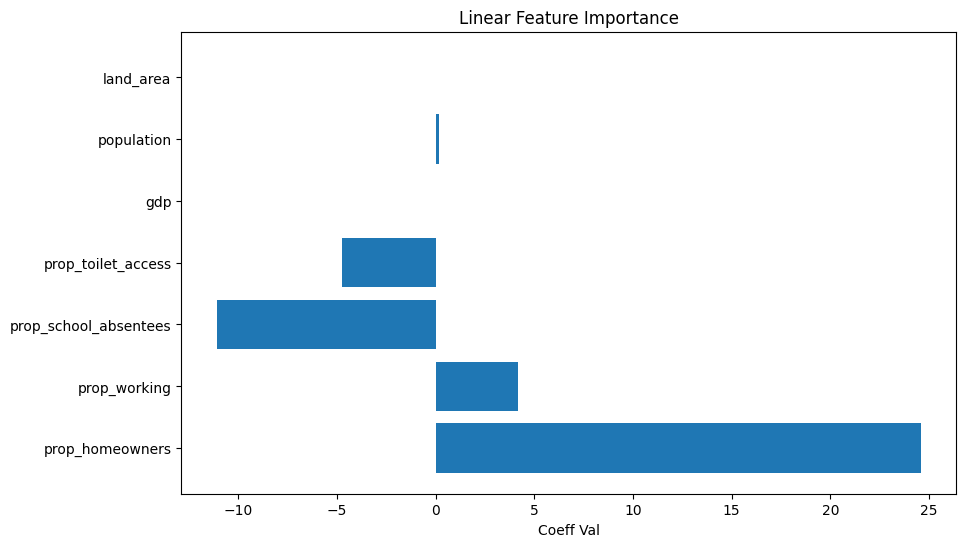

In [ ]:
feature_names = X.columns
coefficients = lr.coef_

# feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('Linear Feature Importance')
plt.show()

## Ridge Regression

*opted for Ridge over Lasso because Ridge regression can handle correlated features and Lasso cannot; our data currently (as of 12/8) has correlated features, but this can change so maybe will switch to Lasso in the future

In [ ]:
pq2_df = ecap_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq2_df.drop('target: energy_capacity', axis=1)
y = pq2_df['target: energy_capacity']

In [ ]:
ecap_df.head()

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,target: energy_capacity
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,201.25
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,4116.45
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,72.67
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,172.62
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,51.54


### Model - chosen features vs. all

Ridge with all features is better than with just important features

In [ ]:
# based off above feature importance graph, prop_toilet, school ab, homeowners
X_imp = X.drop(['land_area','population','gdp','prop_working'], axis=1)

ecap_Ximp_train, ecap_Ximp_test, ecap_y_train, ecap_y_test = train_test_split(X_imp, y, test_size = 0.25, random_state = 42)

rdge_imp = Ridge(alpha=1.0)
rdge_imp.fit(ecap_Ximp_train, ecap_y_train)
ecap_y_pred = rdge_imp.predict(ecap_Ximp_test)

print_metrics(ecap_y_test, ecap_y_pred)

MSE: 73961177.85319799
MAE: 4017.2068019769
RMSE: 8600.06847956445
MAPE: 22.586209706605715


In [ ]:
from sklearn.linear_model import Ridge
# just using all features for now
ecap_X_train, ecap_X_test, ecap_y_train, ecap_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

rdge = Ridge(alpha=1.0)
rdge.fit(ecap_X_train, ecap_y_train)
ecap_y_pred = rdge.predict(ecap_X_test)

print_metrics(ecap_y_test, ecap_y_pred)

MSE: 4028883.917531209
MAE: 1079.5083481587878
RMSE: 2007.2079906006775
MAPE: 3.818639158603981


### Finding 2024

In [ ]:
find_2024 = combined_df[combined_df['Year'] ==2021].reset_index().drop(['index', 'Year','energy_consumption','energy_generation'], axis=1)
predicted_2024_ecap = rdge.predict(find_2024.drop(['Province', 'energy_capacity'],axis=1))
find_2024['2024 Predicted Energy Capacity (MW)'] = predicted_2024_ecap
rd_predicted = find_2024[['Province', '2024 Predicted Energy Capacity (MW)']]

max_caps = []
for i in range(rd_predicted.shape[0]):
    max_caps.append(rd_predicted['2024 Predicted Energy Capacity (MW)'][i] * 8784 / 1000)

rd_predicted['2024 Predicted Maximum Generation (GWh)'] = max_caps

rd_predicted

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Province,2024 Predicted Energy Capacity (MW),2024 Predicted Maximum Generation (GWh)
0,ACEH,1130.984496,9934.567809
1,SUMATERA UTARA,3673.186739,32265.272318
2,SUMATERA BARAT,1031.747498,9062.870019
3,RIAU,2494.716939,21913.593591
4,JAMBI,822.500026,7224.840226
5,SUMATERA SELATAN,1561.794934,13718.806702
6,BENGKULU,1445.207768,12694.705032
7,LAMPUNG,1142.802272,10038.375153
8,KEP. BANGKA BELITUNG,428.845080,3766.975184
9,KEP. RIAU,1494.846458,13130.731288


### Feature Selection

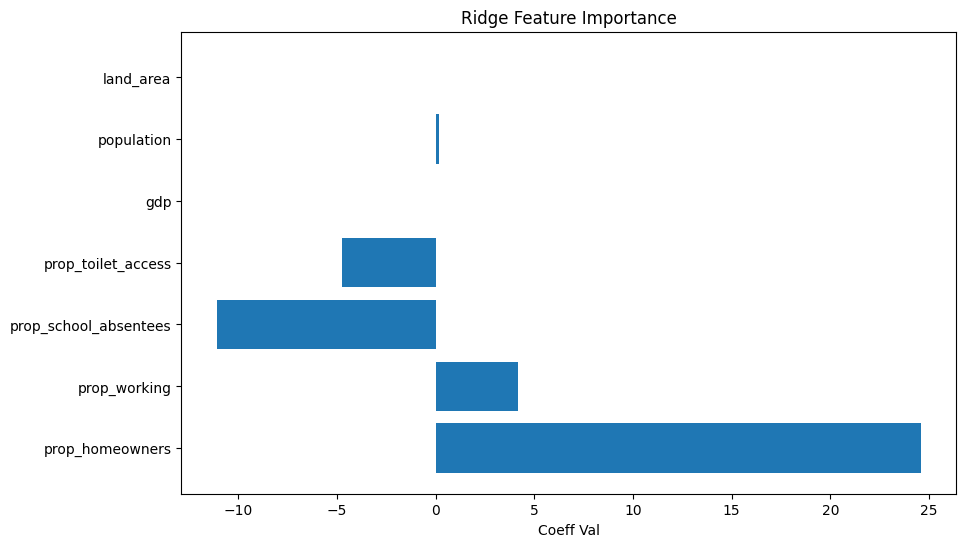

In [ ]:
feature_names = X.columns
coefficients = rdge.coef_

# feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('Ridge Feature Importance')
plt.show()

## LSTM (all) - using all features

all provinces => 1 row = 1 province at 1 year (but province disregarded)

In [ ]:
feature_df = combined_df.drop(['energy_consumption', 'energy_generation', 'energy_capacity'], axis=1)
ecap_all_df = add_target_to_feature_df(feature_df, energy_capacity, 'energy_capacity')
ecap_all_df

num nans in target col: 4


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,target: energy_capacity
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00,201.25
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23,4116.45
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89,72.67
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66,172.62
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72,51.54
...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,2021,75.13,86.18,2.27,72.87,48564.22,1862.6,46914.03,NaN
346,MALUKU UTARA,2021,83.40,89.85,1.08,69.73,52359.85,1299.2,31982.50,NaN
347,PAPUA BARAT,2021,76.03,91.64,3.55,75.48,85072.86,1156.8,319036.05,NaN
348,PAPUA,2021,83.20,94.32,25.55,63.34,235343.25,4355.5,99671.63,NaN


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

pq2_df = ecap_all_df.copy().drop(['Province'], axis=1).dropna()


# Split the data into training (2011-2017) and testing (2018-2021)
train = pq2_df[pq2_df['Year'].between(2011, 2017)]
test = pq2_df[pq2_df['Year'].between(2018, 2021)]

y_train = train['target: energy_capacity']
X_train = train.drop(['Year', 'target: energy_capacity'], axis=1)

y_test = test['target: energy_capacity']
X_test = test.drop(['Year', 'target: energy_capacity'], axis=1)


# Reshape the input data 
n_steps = 3
n_features = X_train.shape[1]
X_train_lstm, y_train_lstm = [], []

for i in range(len(X_train) - n_steps):
    X_train_lstm.append(X_train.iloc[i:(i + n_steps)].values)
    y_train_lstm.append(y_train.iloc[i + n_steps])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

# Reshape the input data for LSTM on the test set
X_test_lstm, y_test_lstm = [], []

for i in range(len(X_test) - n_steps):
    X_test_lstm.append(X_test.iloc[i:(i + n_steps)].values)
    y_test_lstm.append(y_test.iloc[i + n_steps])

X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='linear', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')  # mean squared error

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=50)

# Evaluate the model on the test set
lstm_y_pred = model.predict(X_test_lstm)

Epoch 1/50
2023-12-14 03:28:10.492463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-14 03:28:10.492495: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-14 03:28:10.492511: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-9a2d3571-826e-4759-814d-0768207fd99f): /proc/driver/nvidia/version does not exist
2023-12-14 03:28:10.492717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
7/7 [==============================] - 1s 3ms/step - loss: 250878

In [ ]:
print_metrics(y_test_lstm, lstm_y_pred)

MSE: 316086993.25223047
MAE: 12715.198905487061
RMSE: 17778.83554263975
MAPE: 568.4259099586807


## LSTM (just Indonesia) - using all features

just Indonesia so 1 row = 1 year (unlike before where 1 row =1 year for 1 province but province is hidden)

In [ ]:
# for lstm model, no need df to have target year as can handle that in lookback period parameter
# drop_post_2019 = combined_df[combined_df['Year'] < 2019]
df = combined_df.drop(['energy_consumption', 'energy_generation'], axis=1)
indo_df = df[df['Province']=='INDONESIA']
indo_df

,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
34,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,241991.0,1910931.32
69,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,245416.0,1910931.32
104,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,248818.0,1910931.32
139,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,252165.0,1910931.32
174,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,255462.0,1913578.68
209,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,261891.0,1913578.68
244,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,264161.6,1913578.68
279,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,266911.9,1913578.68
314,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,270203.9,1913578.68
349,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,272682.5,1913578.68


In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
indo_df['scaled_values'] = scaler.fit_transform(indo_df['energy_capacity'].values.reshape(-1,1))
indo_df = indo_df.reset_index().drop('index',axis=1)
indo_df

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,scaled_values
0,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,241991.0,1910931.32,0.000000
1,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,245416.0,1910931.32,0.299014
2,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,248818.0,1910931.32,0.319545
3,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,252165.0,1910931.32,0.563400
4,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,255462.0,1913578.68,0.608179
5,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,261891.0,1913578.68,0.729895
6,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,264161.6,1913578.68,0.910487
7,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,266911.9,1913578.68,0.945928
8,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,270203.9,1913578.68,0.958648
9,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,272682.5,1913578.68,1.000000


In [ ]:
# just imputing nans in 2021's population and land area
indo_df.loc[9, 'population'] = 273753191
indo_df.loc[9, 'land_area'] = 1913578.68 # same as 2020's
indo_df

,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,scaled_values
0,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,241991.0,1910931.32,0.000000
1,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,245416.0,1910931.32,0.299014
2,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,248818.0,1910931.32,0.319545
3,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,252165.0,1910931.32,0.563400
4,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,255462.0,1913578.68,0.608179
5,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,261891.0,1913578.68,0.729895
6,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,264161.6,1913578.68,0.910487
7,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,266911.9,1913578.68,0.945928
8,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,270203.9,1913578.68,0.958648
9,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,273753191.0,1913578.68,1.000000


### 1) Feature Selection

### 2) Train test split, getting x & y

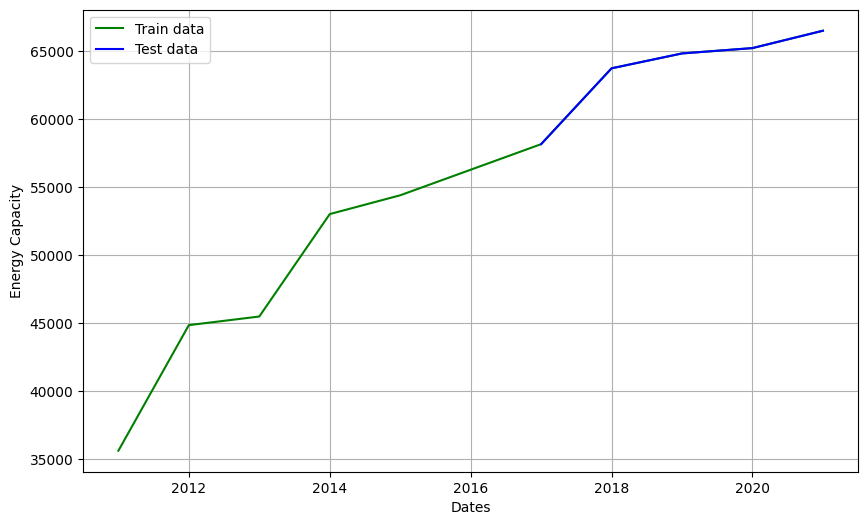

In [ ]:
# split data into train and training set
train_data = indo_df[indo_df['Year'] < 2017] # can only train using data up until 2018 bc newest data is in 2021
test_data = indo_df[indo_df['Year'] >= 2017]

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Energy Capacity')
plt.plot(indo_df['Year'], indo_df['energy_capacity'], 'green', label='Train data')
plt.plot(test_data['Year'], test_data['energy_capacity'], 'blue', label='Test data')
plt.legend()

In [ ]:
print(train_data.columns)

Index(['Province', 'Year', 'energy_capacity', 'prop_homeowners',
       'prop_working', 'prop_school_absentees', 'prop_toilet_access', 'gdp',
       'population', 'land_area', 'scaled_values'],
      dtype='object')


In [ ]:
x_train = []
y_train = []

# choose 3 year as the lookback period; 2000 to predict 2003, and so on
for i in range(3, len(train_data['scaled_values'])):
    historical_values = train_data['scaled_values'][i-3:i]
    # additional features to historical data
    additional_features = ['prop_homeowners', 'prop_working', 'prop_school_absentees', 'prop_toilet_access', 'gdp', 'population', 'land_area']
    additional_feature_values = np.empty((len(historical_values), len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = train_data[feature_name][i-3:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_train.append(combined_features)
    # Check if the index exists in 'scaled_values' before appending to y_train
    if i in train_data.index:
        y_train.append(train_data['scaled_values'][i])
    # y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [ ]:
x_test = []
y_test = test_data['scaled_values']

for i in range(3, len(test_data['scaled_values'])):
    historical_values = test_data['scaled_values'][i-3:i]
    additional_features = ['prop_homeowners', 'prop_working', 'prop_school_absentees', 'prop_toilet_access', 'gdp', 'population', 'land_area']
    additional_feature_values = np.empty((len(historical_values), len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = test_data[feature_name][i-3:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_test.append(combined_features)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

### 3) Initialize basic LSTM model

In [ ]:
!pip install keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Initialize model
lstm = Sequential()

# LSTM layer 1
lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
lstm.add(Dropout(0.25)) ## need to tune this, just use 0.25 for now

# LSTM layer 2
lstm.add(LSTM(units = 50, return_sequences = True))
lstm.add(Dropout(0.25))

# LSTM layer 3
lstm.add(LSTM(units = 50))
lstm.add(Dropout(0.25))

# final layer
lstm.add(Dense(units = 1, activation ='linear'))
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 50)             11800     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
lstm.fit(x_train, y_train, epochs = 50, batch_size=32)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.3437 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3039 - accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 0.2530 - accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.2625 - accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1464 - accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 61ms/step - loss: 0.1075 - accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.0000e+00
Epoch 8/50
1/1 [==============================] - 0s 10ms/step - loss: 0.0636 - accuracy: 0.0000e+00
Epoch 9/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0582 - accuracy: 0.0000e+00
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 0.0518 - accuracy: 0.0000e

### 4) Prediction Results

In [ ]:
# predict on test data
predicted_capacity = lstm.predict(x_test)
predicted_capacity = scaler.inverse_transform(predicted_capacity)

1/1 [==============================] - 1s 990ms/step


In [ ]:
x_test

array([[[7.29895331e-01, 7.96100000e+01, 8.70600000e+01, 4.15000000e+00,
         7.78400000e+01, 1.35898257e+07, 2.61891000e+05, 1.91357868e+06],
        [9.10487144e-01, 8.00200000e+01, 8.68500000e+01, 3.96000000e+00,
         7.93500000e+01, 1.48387560e+07, 2.64161600e+05, 1.91357868e+06],
        [9.45927833e-01, 8.00700000e+01, 8.70700000e+01, 3.57000000e+00,
         8.11300000e+01, 1.58326572e+07, 2.66911900e+05, 1.91357868e+06]],

       [[9.10487144e-01, 8.00200000e+01, 8.68500000e+01, 3.96000000e+00,
         7.93500000e+01, 1.48387560e+07, 2.64161600e+05, 1.91357868e+06],
        [9.45927833e-01, 8.00700000e+01, 8.70700000e+01, 3.57000000e+00,
         8.11300000e+01, 1.58326572e+07, 2.66911900e+05, 1.91357868e+06],
        [9.58648109e-01, 8.01000000e+01, 8.66600000e+01, 3.19000000e+00,
         8.28600000e+01, 1.54380175e+07, 2.70203900e+05, 1.91357868e+06]]])

In [ ]:
predicted_capacity

array([[54097.65],
       [54097.65]], dtype=float32)

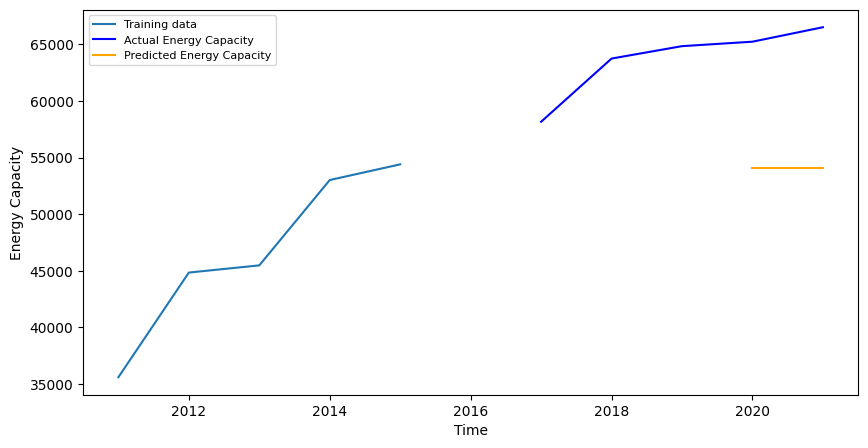

In [ ]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Year'], train_data['energy_capacity'], label='Training data')
plt.plot(test_data['Year'], test_data['energy_capacity'], color = 'blue', label='Actual Energy Capacity')
plt.plot(test_data[3:]['Year'], predicted_capacity, color = 'orange',label='Predicted Energy Capacity')

plt.xlabel('Time')
plt.ylabel('Energy Capacity')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y_t = test_data[3:]['energy_capacity'].values
y_p = predicted_capacity

print_metrics(y_t, y_p)

MSE: 139116063.67500865
MAE: 11777.411562499998
RMSE: 11794.747291697633
MAPE: 0.17870673455750796


## Intro to ARIMAX

In [ ]:
!pip install statsmodels



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
just_energy_year = indo_df[['Year','energy_capacity']]
just_energy_year.index = pd.to_datetime(just_energy_year["Year"].astype(str), format='%Y')
just_energy_year.drop('Year',axis=1,inplace=True)
just_energy_year

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,energy_capacity
Year,
2011-01-01,35596.74
2012-01-01,44841.54
2013-01-01,45476.31
2014-01-01,53015.70
2015-01-01,54400.17
2017-01-01,58163.33
2018-01-01,63746.79
2019-01-01,64842.53
2020-01-01,65235.81


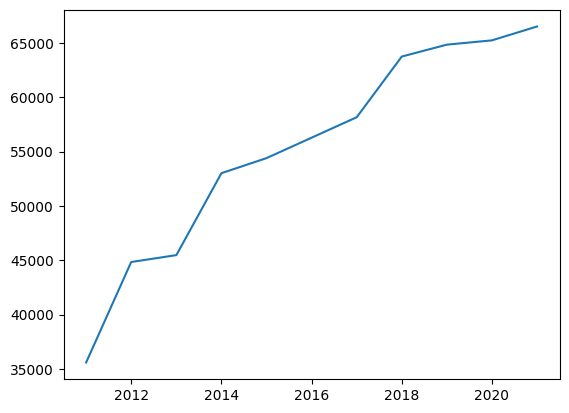

In [ ]:
plt.plot(just_energy_year)

### 1) Stationary 

Find autocorrelation using moving average/moving STD test and Adfuller test . There are 2 primary way to determine whether a given time series is stationary.
1. Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).
2. Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics

In [ ]:
def get_stationarity(time_series):
    rolling_mean = time_series.rolling(window=4).mean()
    rolling_std = time_series.rolling(window=4).std()

    # rolling statistics plot
    original = plt.plot(time_series, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    result = adfuller(time_series['energy_capacity'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

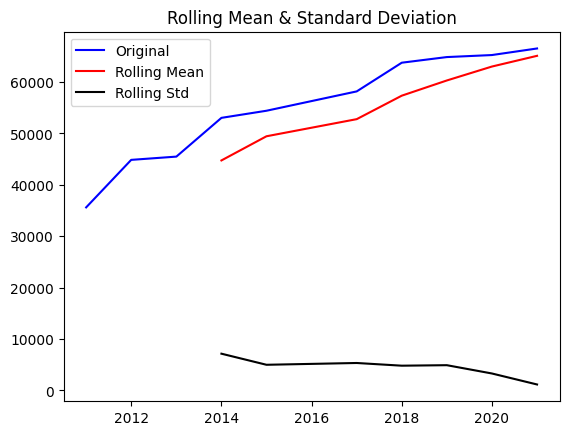

ADF Statistic: -2.4602964856808502
p-value: 0.12543582583454171
Critical Values:
	1%: -4.473135048010974
	5%: -3.28988060356653
	10%: -2.7723823456790124


In [ ]:
get_stationarity(just_energy_year)

Indicators time series is already stationary:

- Rolling mean and std fairly flat

- p-value is relatively high (0.12 >> 0.05 cutoff)

### 2) Get order of ARIMA using autoarima or correlogram

In [ ]:
!pip install pmdarima
#This is to determine the order of the ARIMA model
from pmdarima import auto_arima

# Fit an auto ARIMA model to determine the best parameters (p, d, q)
auto_arima_model = auto_arima(just_energy_year)

# Get the summary of the auto ARIMA model
print(auto_arima_model.summary())


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -99.621
Date:                Thu, 14 Dec 2023   AIC                            205.242
Time:                        03:28:41   BIC                            206.150
Sample:                             0   HQIC                           204.246
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3024.3831   7566.203      0.400      0.689   -1.18e+04    1.79e+04
ar.L1          0.9

### 3) Run ARIMA using statsmodels

## ARIMA (no exogenous)

### Model

In [ ]:
just_energy_year.index

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [ ]:
# create train/test split so we can see how accurate our model is
tr_start,tr_end = '2011-01-01','2017-01-01'
te_start,te_end = '2018-01-01','2020-01-01'
tra = just_energy_year["energy_capacity"][tr_start:tr_end].dropna()
tes = just_energy_year["energy_capacity"][te_start:te_end].dropna()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12296D+00    |proj g|=  5.99329D-01

At iterate    5    f=  2.95873D+00    |proj g|=  2.97541D-03

At iterate   10    f=  2.95842D+00    |proj g|=  1.39057D-02

At iterate   15    f=  2.95824D+00    |proj g|=  1.72566D-04

At iterate   20    f=  2.95823D+00    |proj g|=  5.21058D-03

At iterate   25    f=  2.95634D+00    |proj g|=  4.34131D-02

At iterate   30    f=  2.95328D+00    |proj g|=  1.56565D-01

At iterate   35    f=  2.94559D+00    |proj g|=  3.73980D-02

At iterate   40    f=  2.94395D+00    |proj g|=  1.81513D-02

At iterate   45    f=  2.94250D+00    |proj g|=  6.77281D-02

At iterate   50    f=  2.93363D+00    |proj g|=  1.07913D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

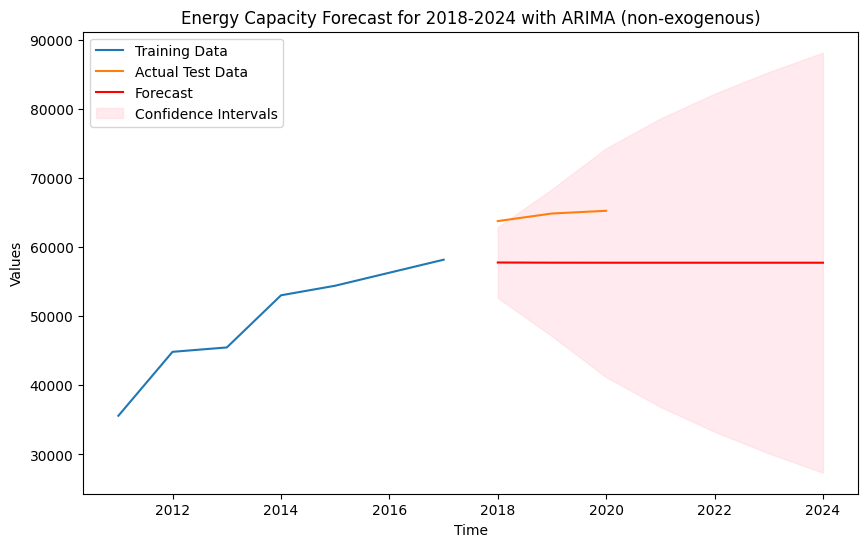

In [ ]:
# Train SARIMAX model
model = SARIMAX(tra, order=(2, 1, 2), enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

# Generate future dates for prediction (2022-2024)
future_dates = pd.date_range(start='2018-01-01', end='2024-01-01', freq='AS')  # Adjust the date range as needed

# Forecast for the future period
forecast = results.get_forecast(steps=len(future_dates))

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean.values
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and dates as index
forecast_df = pd.DataFrame(forecast_values, index=future_dates, columns=['Forecast'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(tra.index, tra.values, label='Training Data')
plt.plot(tes.index, tes.values, label='Actual Test Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', label='Forecast')

# Fill confidence intervals
plt.fill_between(
    forecast_df.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3,
    label='Confidence Intervals'
)

plt.title('Energy Capacity Forecast for 2018-2024 with ARIMA (non-exogenous)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.show()

In [ ]:
forecast.predicted_mean.values

array([57756.45278464, 57732.10023243, 57725.72637632, 57725.44571684,
       57725.34380044, 57725.34114956, 57725.33948227])

In [ ]:
print_metrics(tes.values, forecast.predicted_mean.values[:3])

MSE: 47614569.15597957
MAE: 6870.283535536556
RMSE: 6900.331090315853
MAPE: 0.10624993069947959


## ARIMAX (exogenous)

### Feature Selection

In [ ]:
df = combined_df.drop(['energy_consumption', 'energy_generation'], axis=1)
df["Year"] = pd.to_datetime(df["Year"].astype(str), format='%Y')
df

,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011-01-01,159.26,79.02,87.13,3.17,60.34,108217.63,4619.0,57956.00
1,SUMATERA UTARA,2011-01-01,2450.67,66.07,90.28,2.34,74.88,377037.10,13220.0,72981.23
2,SUMATERA BARAT,2011-01-01,33.45,69.51,86.66,2.02,54.65,118674.29,4933.0,42012.89
3,RIAU,2011-01-01,111.23,68.42,91.90,2.39,83.81,485649.34,5726.0,87023.66
4,JAMBI,2011-01-01,12.82,78.02,90.87,3.56,68.12,103522.91,3168.0,8201.72
...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,2021-01-01,390.74,75.13,86.18,2.27,72.87,48564.22,1862.6,46914.03
346,MALUKU UTARA,2021-01-01,157.88,83.40,89.85,1.08,69.73,52359.85,1299.2,31982.50
347,PAPUA BARAT,2021-01-01,267.51,76.03,91.64,3.55,75.48,85072.86,1156.8,319036.05
348,PAPUA,2021-01-01,525.64,83.20,94.32,25.55,63.34,235343.25,4355.5,99671.63


In [ ]:
# correlation using data from all provinces
df.corr()

,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
energy_capacity,1.000000,0.040100,-0.177747,-0.011019,0.106990,0.973463,0.965792,0.909897
prop_homeowners,0.040100,1.000000,0.202869,0.271733,-0.273427,-0.052434,0.032656,0.000806
prop_working,-0.177747,0.202869,1.000000,0.302869,-0.272902,-0.170867,-0.159948,-0.008759
prop_school_absentees,-0.011019,0.271733,0.302869,1.000000,-0.383451,-0.027603,-0.002883,0.021792
prop_toilet_access,0.106990,-0.273427,-0.272902,-0.383451,1.000000,0.135625,0.077649,0.031345
gdp,0.973463,-0.052434,-0.170867,-0.027603,0.135625,1.000000,0.951891,0.910573
population,0.965792,0.032656,-0.159948,-0.002883,0.077649,0.951891,1.000000,0.941790
land_area,0.909897,0.000806,-0.008759,0.021792,0.031345,0.910573,0.941790,1.000000


FOR ALL PROVINCES: seems like the most correlate features are GDP,  Population, and Land Area!

In [ ]:
# correlation using data from just indonesia
indo_df.corr()

,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,scaled_values
Year,1.000000,0.965673,0.117361,-0.807730,-0.973808,0.997333,0.993599,0.502613,0.861640,0.965673
energy_capacity,0.965673,1.000000,0.181120,-0.795983,-0.924323,0.966348,0.971993,0.378730,0.855406,1.000000
prop_homeowners,0.117361,0.181120,1.000000,0.208811,0.032468,0.145025,0.099604,0.264916,0.316045,0.181120
prop_working,-0.807730,-0.795983,0.208811,1.000000,0.793628,-0.798312,-0.814878,0.016269,-0.808709,-0.795983
prop_school_absentees,-0.973808,-0.924323,0.032468,0.793628,1.000000,-0.957859,-0.962177,-0.512784,-0.748398,-0.924323
prop_toilet_access,0.997333,0.966348,0.145025,-0.798312,-0.957859,1.000000,0.992591,0.506168,0.877704,0.966348
gdp,0.993599,0.971993,0.099604,-0.814878,-0.962177,0.992591,1.000000,0.482483,0.871796,0.971993
population,0.502613,0.378730,0.264916,0.016269,-0.512784,0.506168,0.482483,1.000000,0.272257,0.378730
land_area,0.861640,0.855406,0.316045,-0.808709,-0.748398,0.877704,0.871796,0.272257,1.000000,0.855406
scaled_values,0.965673,1.000000,0.181120,-0.795983,-0.924323,0.966348,0.971993,0.378730,0.855406,1.000000


FOR INDONESIA: seems like the most correlated features are prop_working, prop_school_absent, prop_toilet_access, gdp, land_area (all over 0.75)

In [ ]:
exog_x = indo_df[["prop_working", "prop_school_absentees", "prop_toilet_access","Year", "gdp", "land_area"]]
exog_x = exog_x.set_index("Year")

exog_x_tra = exog_x.loc["2010-01-01":"2017-01-01", :]
exog_x_tra.index = pd.to_datetime(exog_x_tra.index, format='%Y')

exog_x_test = exog_x.loc["2017-01-01":"2021-01-01", :]
exog_x_test.index = pd.to_datetime(exog_x_test.index, format='%Y')

f_amx = just_energy_year.loc['2011-01-01':'2017-01-01',:] 
f_amx_test = just_energy_year.loc["2018-01-01":"2021-01-01", :]
f_amx_test

,energy_capacity
Year,
2018-01-01,63746.79
2019-01-01,64842.53
2020-01-01,65235.81
2021-01-01,66514.31


### Model

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
 This problem is unconstrained.
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)

 Line search cannot locate

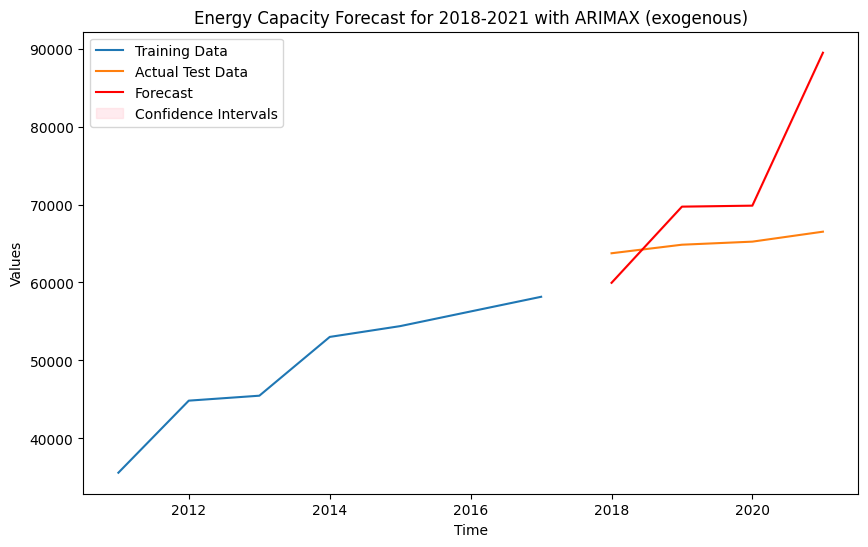

In [ ]:
# Train SARIMAX model
model = SARIMAX(tra, order=(2, 1, 2), exog=exog_x_tra[["prop_working", "prop_school_absentees", "prop_toilet_access", "gdp", "land_area"]], enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

# Generate future dates for prediction (2022-2024)
future_dates = pd.date_range(start='2018-01-01', end='2021-01-01', freq='AS')  # Adjust the date range as needed

# Forecast for the future period
forecast = results.get_forecast(steps=4, exog=exog_x_test[["prop_working", "prop_school_absentees", "prop_toilet_access", "gdp", "land_area"]])

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean.values
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and dates as index
forecast_df = pd.DataFrame(forecast_values, index=future_dates, columns=['Forecast'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(f_amx.index, f_amx.values, label='Training Data')  # Assuming 'data' is a pandas Series or DataFrame
plt.plot(f_amx_test, label='Actual Test Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', label='Forecast')

# Fill confidence intervals
plt.fill_between(
    forecast_df.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink', alpha=0.3,
    label='Confidence Intervals'
)

plt.title('Energy Capacity Forecast for 2018-2021 with ARIMAX (exogenous)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.show()

In [ ]:
print_metrics(f_amx_test.values, forecast.predicted_mean.values)

MSE: 146602433.588705
MAE: 9061.391844382595
RMSE: 12107.949190044737
MAPE: 0.14965353555696598


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a2d3571-826e-4759-814d-0768207fd99f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>